In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import Imputer

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)

mpl.rc(group='figure', figsize=(10,8))
plt.style.use('seaborn')

In [3]:
filepath = 'dataset'
X_train = pd.read_csv(filepath + '/dengue_features_train.csv')
Y_train = pd.read_csv(filepath + '/dengue_labels_train.csv')
# only total_cases column
Y_train = pd.DataFrame(Y_train['total_cases'])
X_test = pd.read_csv(filepath + '/dengue_features_test.csv')

In [42]:
def get_null_percentages(df):
    return df.isnull().sum()/df.shape[0] * 100

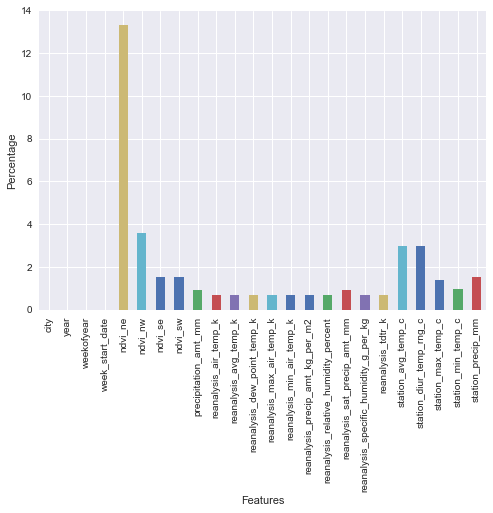

In [43]:
null_percentages = get_null_percentages(X_train)
# type(null_percentages)
null_percentages.plot.bar()
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.show()
# plt.bar(null_percentages)

In [4]:
# variable type change
X_train.week_start_date = pd.to_datetime(X_train.week_start_date)
X_test.week_start_date = pd.to_datetime(X_test.week_start_date)
# concat X and Y
XY_train = pd.concat([Y_train, X_train], axis=1)
# splitting into two cities
XY_sj = XY_train.loc[XY_train.city == 'sj', :]
XY_iq = XY_train.loc[XY_train.city == 'iq', :]

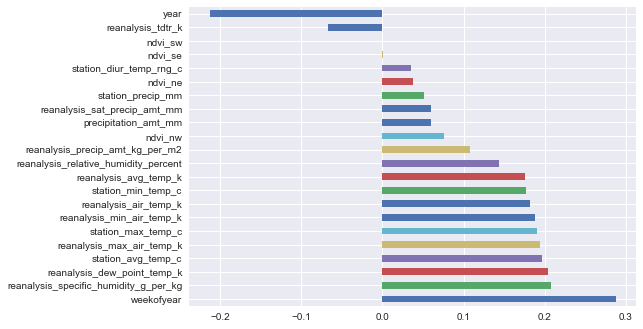

In [5]:
# sj feature-total_cases correlation
XY_sj.corr().total_cases.drop('total_cases').sort_values(ascending=False).plot.barh()

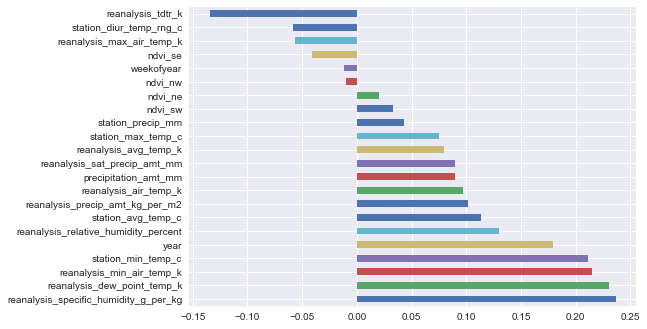

In [6]:
# iq feature-total_cases correlation
XY_iq.corr().total_cases.drop('total_cases').sort_values(ascending=False).plot.barh()

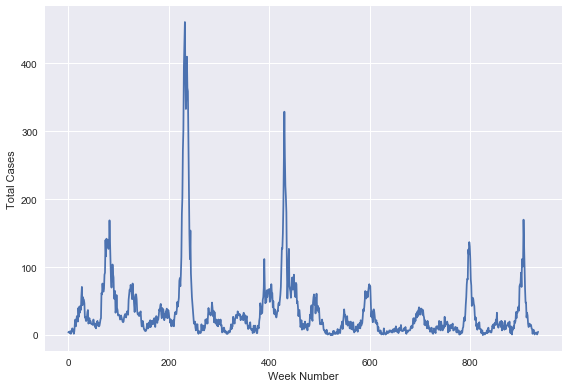

In [7]:
XY_sj.total_cases.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Total Cases')
plt.tight_layout()

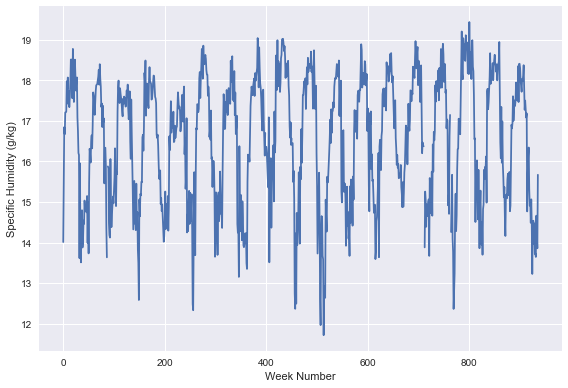

In [8]:
XY_sj.reanalysis_specific_humidity_g_per_kg.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Specific Humidity (g/kg)')
plt.tight_layout()

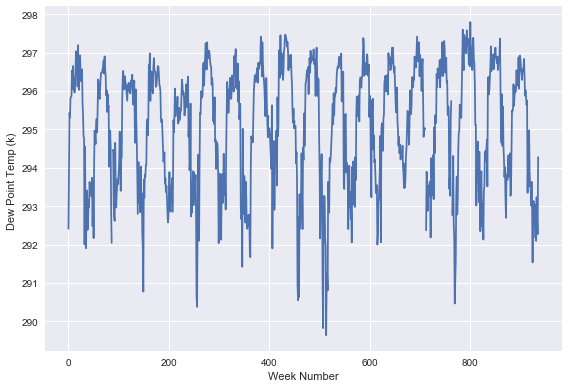

In [9]:
XY_sj.reanalysis_dew_point_temp_k.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Dew Point Temp (k) ')
plt.tight_layout()

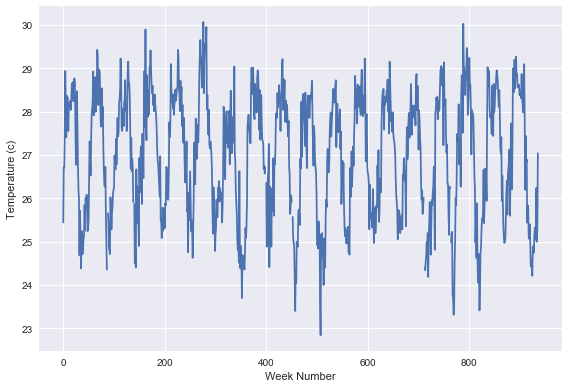

In [10]:
XY_sj.station_avg_temp_c.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Temperature (c)')
plt.tight_layout()

In [11]:
X_train_sj = X_train.loc[X_train.city == 'sj', :].copy()
X_train_iq = X_train.loc[X_train.city == 'iq', :].copy()

Y_train_sj = Y_train.loc[X_train.city == 'sj', :].copy()
Y_train_iq = Y_train.loc[X_train.city == 'iq', :].copy()

X_test_sj = X_test.loc[X_test.city == 'sj', :].copy()
X_test_iq = X_test.loc[X_test.city == 'iq', :].copy()

In [12]:
keys = ['city', 'year', 'weekofyear']

all_features = ['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']

sj_features = ['reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 
            'station_avg_temp_c',  'station_max_temp_c', 'station_min_temp_c']

iq_features = ['reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 
            'station_avg_temp_c',  'station_max_temp_c', 'station_min_temp_c','reanalysis_tdtr_k']

new_features = ['recent_mean_dew_point', 'recent_mean_spec_humid', 'recent_sum_precip']

time_series_features = ['week_start_date']

sj_drop_features = list(set(all_features) - set(sj_features) - set(keys) - set(time_series_features))
print('drop_features:\n', sorted(sj_drop_features))

iq_drop_features = list(set(all_features) - set(iq_features) - set(keys) - set(time_series_features))
print('drop_features:\n', sorted(iq_drop_features))


drop_features:
 ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'station_precip_mm']
drop_features:
 ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'station_diur_temp_rng_c', 'station_precip_mm']


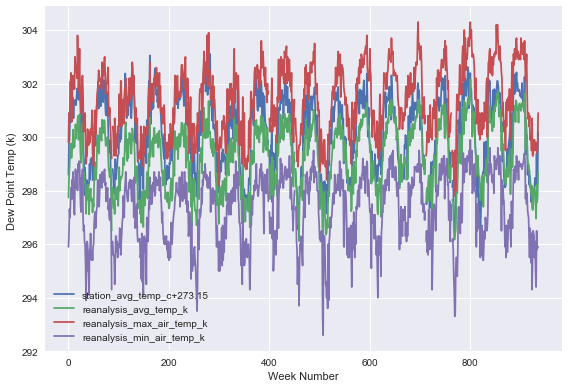

In [13]:
#to fill the missing values
(XY_sj.station_avg_temp_c+273.15).plot(kind='line',label="station_avg_temp_c+273.15")
XY_sj.reanalysis_avg_temp_k.plot(kind='line',label="reanalysis_avg_temp_k")
XY_sj.reanalysis_max_air_temp_k.plot(kind='line',label="reanalysis_max_air_temp_k")
XY_sj.reanalysis_min_air_temp_k.plot(kind='line',label="reanalysis_min_air_temp_k")
plt.xlabel('Week Number')
plt.ylabel('Dew Point Temp (k) ')
plt.legend()
plt.tight_layout()

In [14]:
#to find the missing values in station_avg_temp_c -> use other temperature values.
def impute_redundant_features(df):
    df['reanalysis_avg_temp_c'] = df.reanalysis_avg_temp_k - 273.15
    df.reanalysis_avg_temp_c -= (df.reanalysis_avg_temp_c - df.station_avg_temp_c).mean()
    df.loc[df.station_avg_temp_c.isnull(), 'station_avg_temp_c'] = df.reanalysis_avg_temp_c

    df['reanalysis_max_air_temp_c'] = df.reanalysis_max_air_temp_k - 273.15
    df.reanalysis_max_air_temp_c -= (df.reanalysis_max_air_temp_c - df.station_max_temp_c).mean()
    df.loc[df.station_max_temp_c.isnull(), 'station_max_temp_c'] = df.reanalysis_max_air_temp_c

    df['reanalysis_min_air_temp_c'] = df.reanalysis_min_air_temp_k - 273.15
    df.reanalysis_min_air_temp_c -= (df.reanalysis_min_air_temp_c - df.station_min_temp_c).mean()
    df.loc[df.station_min_temp_c.isnull(), 'station_min_temp_c'] = df.reanalysis_min_air_temp_c
    
    # Drop the temporary columns that we just added
    df.drop(['reanalysis_avg_temp_c', 'reanalysis_max_air_temp_c', 
                  'reanalysis_min_air_temp_c'], axis=1, inplace=True)
    
    return df

In [15]:
X_train_sj = impute_redundant_features(X_train_sj)
X_train_iq = impute_redundant_features(X_train_iq)

X_test_sj = impute_redundant_features(X_test_sj)
X_test_iq = impute_redundant_features(X_test_iq)

In [16]:
#can be further improved by considering correlation, ffill
def impute_missing_values(df, imputer, features):
    imputer.fit(df[features])
    df[features] = imputer.transform(df[features])
    return df

In [17]:
imputer_sj = Imputer(strategy='mean')
X_train_sj = impute_missing_values(X_train_sj, imputer_sj,sj_features)
X_test_sj = impute_missing_values(X_test_sj, imputer_sj,sj_features)

imputer_iq = Imputer(strategy='mean')
X_train_iq = impute_missing_values(X_train_iq, imputer_iq,iq_features)
X_test_iq = impute_missing_values(X_test_iq, imputer_iq,iq_features)
